### **Plants Seedling Classification**

 ***Background and Context***

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term.

The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can benefit the workers in this field, as the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning. The ability to do so far more efficiently and even more effectively than experienced manual labor could lead to better crop yields, the freeing up of human involvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.

**Objective**

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has provided the data containing images of unique plants belonging to 12 different species. You being a data scientist, need to build a Convolutional Neural Network model which would classify the plant seedlings into their respective 12 categories.

# ***List of Plant species**
Black-grass
Charlock
Cleavers
Common Chickweed
Common Wheat
Fat Hen
Loose Silky-bent
Maize
Scentless Mayweed
Shepherds Purse
Small-flowered Cranesbill
Sugar beet

*   List item
*   List item



In [1]:
import os
import numpy as np                                                                              
import pandas as pd                                                                          
import matplotlib.pyplot as plt                                                                 
import math                                                                                  
import cv2                                                                                       
import seaborn as sns                                                                            


# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                             
from tensorflow.keras.models import Sequential                                                  
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization 
from tensorflow.keras.optimizers import Adam,SGD                                               
from sklearn import preprocessing                                                                
from sklearn.model_selection import train_test_split                                           
from sklearn.metrics import confusion_matrix 
from google.colab.patches import cv2_imshow 
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16                                                     

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')  


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
images=np.load('/content/drive/MyDrive/images.npy')

In [4]:
Label=pd.read_csv("/content/drive/MyDrive/Labels.csv")

In [5]:
print(images.shape) # There are 4750 RGB images of shape 128 x 128 X 3, each image having 3 channels.
print(Label.shape)

(4750, 128, 128, 3)
(4750, 1)


Plotting images using OpenCV and matplotlib

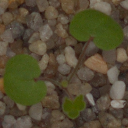

In [6]:
cv2_imshow(images[7])

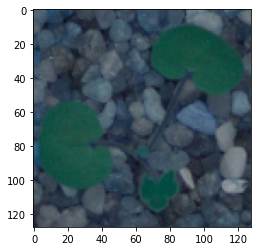

In [7]:
plt.imshow(images[7])

In [8]:
# Converting the images from BGR to RGB using cvtColor function of OpenCV
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

Exploratory Data Analysis

In [9]:
def plot_images(images,Label):
  num_classes=12                                                                
  categories=np.unique(Label)   
  keys=dict(Label['Label'])                                                     
  rows = 4                                                                      
  cols = 4                                                                        
  fig = plt.figure(figsize=(10, 8))                                         
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(Label))                        
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      
          ax.imshow(images[random_index, :])                                      
          ax.set_title(keys[random_index])
  plt.show()

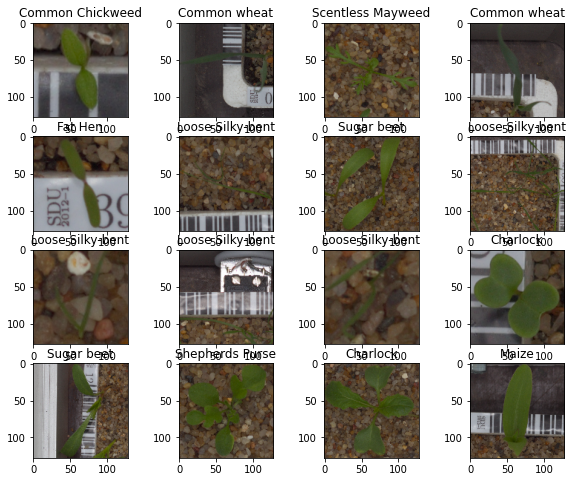

In [10]:
plot_images(images,Label)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text major ticklabel objects>)

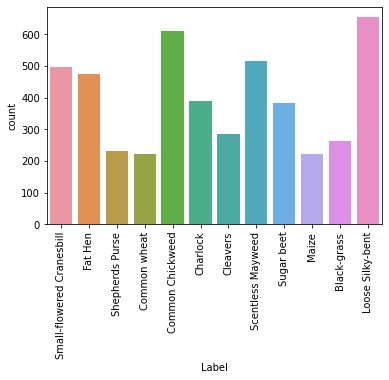

In [11]:
sns.countplot(Label['Label'])
plt.xticks(rotation='vertical')

There are 12 different plants, and the data set is imbalanced. Loose Silky bend has more than 600 images, while Shepherds Purse and Maize has less than 300 images.

Visualizing images using Gaussian Blur

In [12]:
images_gb=[] #used gaussian blur to remove noise
for i in range(len(images)):
  images_gb.append(cv2.GaussianBlur(images[i], ksize =(3,3),sigmaX =  0))

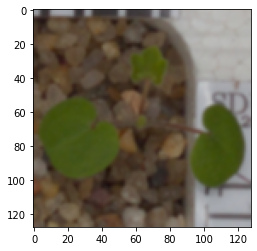

In [13]:
plt.imshow(images_gb[2])

Splitting the dataset

In [14]:
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_gb),Label , test_size=0.1, random_state=42,stratify=Label)
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=0.1, random_state=42,stratify=y_temp)

In [15]:
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(3847, 128, 128, 3) (3847, 1)
(428, 128, 128, 3) (428, 1)
(475, 128, 128, 3) (475, 1)


In [16]:
from sklearn.utils import class_weight    

labelList = Label.Label.unique()    
class_weights = class_weight.compute_class_weight(class_weight = "balanced",
                                                  classes = np.array(labelList),
                                                  y = y_train.values.reshape(-1)
                                                  )
class_weights = dict(zip(np.array(range(len(labelList))), class_weights))
class_weights

{0: 0.7974709784411277,
 1: 0.8348524305555556,
 2: 1.714349376114082,
 3: 1.7909683426443204,
 4: 0.6476430976430977,
 5: 1.0145042194092826,
 6: 1.3818247126436782,
 7: 0.7669457735247209,
 8: 1.0275106837606838,
 9: 1.7909683426443204,
 10: 1.5050860719874803,
 11: 0.604874213836478}

Encoding the target labels

In [17]:
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded=enc.transform(y_val)
y_test_encoded=enc.transform(y_test)

Data Normalization

In [18]:
X_train_normalized = X_train.astype('float32')/255.0   #divide all the pixel values by 255 to standardize the images to have values between 0-1.
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

Model Building - Convolutional Neural Network (CNN)

In [19]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [20]:
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [21]:
model1=Sequential()
model1.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(128, 128, 3))) 
model1.add(MaxPooling2D((2, 2), padding = 'same'))
model1.add(Conv2D(32,(3,3),activation='relu'))
model1.add(MaxPooling2D(2,2))
model1.add(Conv2D(32,(3,3),activation='relu'))
model1.add(MaxPooling2D(2,2))
model1.add(Flatten())
model1.add(Dense(32, activation='relu'))
model1.add(Dense(32, activation='relu'))
model1.add(Dense(12, activation='softmax'))

In [22]:
opt=Adam()
model1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0

In [23]:
history_1 = model1.fit(
            X_train_normalized, y_train_encoded,class_weight=class_weights,
            epochs=20,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=16,
            verbose=2
)

Epoch 1/20
241/241 - 118s - loss: 2.6456 - accuracy: 0.2046 - val_loss: 1.8661 - val_accuracy: 0.3995 - 118s/epoch - 491ms/step
Epoch 2/20
241/241 - 115s - loss: 1.8135 - accuracy: 0.4229 - val_loss: 1.5261 - val_accuracy: 0.4883 - 115s/epoch - 479ms/step
Epoch 3/20
241/241 - 113s - loss: 1.5642 - accuracy: 0.4812 - val_loss: 1.3254 - val_accuracy: 0.5467 - 113s/epoch - 470ms/step
Epoch 4/20
241/241 - 114s - loss: 1.2767 - accuracy: 0.5740 - val_loss: 1.1693 - val_accuracy: 0.6355 - 114s/epoch - 474ms/step
Epoch 5/20
241/241 - 115s - loss: 1.0898 - accuracy: 0.6408 - val_loss: 1.1115 - val_accuracy: 0.6589 - 115s/epoch - 476ms/step
Epoch 6/20
241/241 - 114s - loss: 0.9176 - accuracy: 0.6938 - val_loss: 1.0336 - val_accuracy: 0.6706 - 114s/epoch - 474ms/step
Epoch 7/20
241/241 - 114s - loss: 0.7912 - accuracy: 0.7247 - val_loss: 1.0949 - val_accuracy: 0.6682 - 114s/epoch - 472ms/step
Epoch 8/20
241/241 - 112s - loss: 0.7044 - accuracy: 0.7577 - val_loss: 0.9702 - val_accuracy: 0.6986 - 

In [24]:
accuracy = model1.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 3s - loss: 1.3642 - accuracy: 0.7053 - 3s/epoch - 203ms/step


In [25]:
y_pred1=model1.predict(X_test_normalized)

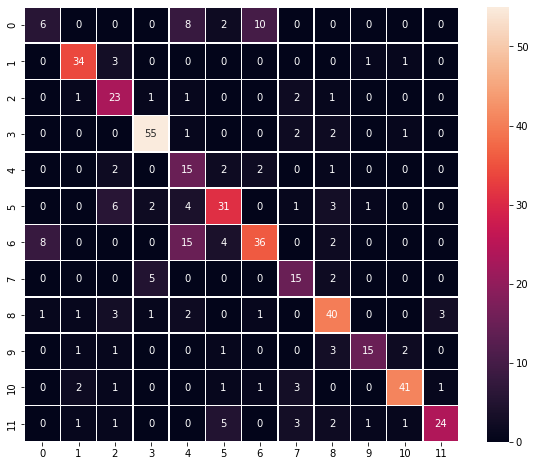

In [26]:
y_pred1_arg=np.argmax(y_pred1,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred1_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

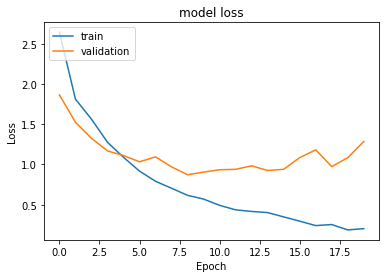

In [27]:
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [28]:
from sklearn.metrics import classification_report
print(classification_report((y_test_arg),y_pred1_arg))

              precision    recall  f1-score   support

           0       0.40      0.23      0.29        26
           1       0.85      0.87      0.86        39
           2       0.57      0.79      0.67        29
           3       0.86      0.90      0.88        61
           4       0.33      0.68      0.44        22
           5       0.67      0.65      0.66        48
           6       0.72      0.55      0.63        65
           7       0.58      0.68      0.62        22
           8       0.71      0.77      0.74        52
           9       0.83      0.65      0.73        23
          10       0.89      0.82      0.85        50
          11       0.86      0.63      0.73        38

    accuracy                           0.71       475
   macro avg       0.69      0.69      0.68       475
weighted avg       0.73      0.71      0.71       475



Class 0 has a lower recall score, so the model does not predict class 0 well. Class 3 is predicted well and has a higher recall score than the other class. 

First model is overfitting. Let's try data augmentation and Batch Normalization to solve the problem.

Model 2

In [29]:
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [30]:
model2=Sequential()
model2.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(128, 128, 3))) 
model2.add(MaxPooling2D((2, 2), padding = 'same'))
model2.add(BatchNormalization())
model2.add(Conv2D(32,(3,3),activation='relu'))
model2.add(MaxPooling2D(2,2))
model2.add(BatchNormalization())
model2.add(Conv2D(32,(3,3),activation='relu'))
model2.add(MaxPooling2D(2,2))
model2.add(BatchNormalization())
model2.add(Flatten())
model2.add(Dense(32, activation='relu'))
model2.add(Dropout(0.1))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(12, activation='softmax'))

In [31]:
opt=Adam()
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                        

In [32]:
history_2 = model2.fit(
            X_train_normalized, y_train_encoded,class_weight=class_weights,
            epochs=20,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=16,
            verbose=2
)

Epoch 1/20
241/241 - 132s - loss: 1.9985 - accuracy: 0.3915 - val_loss: 5.0652 - val_accuracy: 0.1379 - 132s/epoch - 547ms/step
Epoch 2/20
241/241 - 131s - loss: 1.2174 - accuracy: 0.6142 - val_loss: 4.1030 - val_accuracy: 0.1636 - 131s/epoch - 545ms/step
Epoch 3/20
241/241 - 128s - loss: 0.8669 - accuracy: 0.7180 - val_loss: 1.6116 - val_accuracy: 0.5280 - 128s/epoch - 532ms/step
Epoch 4/20
241/241 - 128s - loss: 0.6378 - accuracy: 0.7962 - val_loss: 8.1457 - val_accuracy: 0.1682 - 128s/epoch - 533ms/step
Epoch 5/20
241/241 - 129s - loss: 0.5510 - accuracy: 0.8217 - val_loss: 1.2408 - val_accuracy: 0.6495 - 129s/epoch - 537ms/step
Epoch 6/20
241/241 - 130s - loss: 0.4211 - accuracy: 0.8640 - val_loss: 0.7879 - val_accuracy: 0.7991 - 130s/epoch - 540ms/step
Epoch 7/20
241/241 - 131s - loss: 0.3338 - accuracy: 0.8898 - val_loss: 1.9382 - val_accuracy: 0.5397 - 131s/epoch - 543ms/step
Epoch 8/20
241/241 - 129s - loss: 0.3205 - accuracy: 0.8952 - val_loss: 1.0434 - val_accuracy: 0.7523 - 

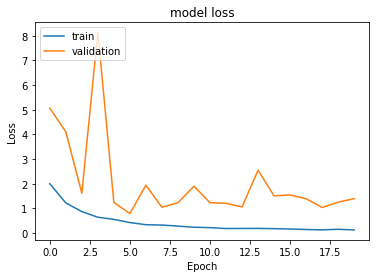

In [33]:
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [34]:
accuracy = model2.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 3s - loss: 1.6642 - accuracy: 0.7284 - 3s/epoch - 225ms/step


In [35]:
y_pred2=model2.predict(X_test_normalized)

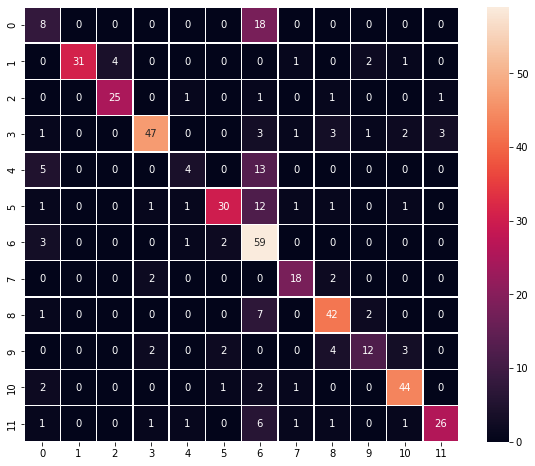

In [36]:
y_pred2_arg=np.argmax(y_pred2,axis=1)

confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred2_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

In [37]:
print(classification_report((y_test_arg),y_pred2_arg))

              precision    recall  f1-score   support

           0       0.36      0.31      0.33        26
           1       1.00      0.79      0.89        39
           2       0.86      0.86      0.86        29
           3       0.89      0.77      0.82        61
           4       0.50      0.18      0.27        22
           5       0.86      0.62      0.72        48
           6       0.49      0.91      0.63        65
           7       0.78      0.82      0.80        22
           8       0.78      0.81      0.79        52
           9       0.71      0.52      0.60        23
          10       0.85      0.88      0.86        50
          11       0.87      0.68      0.76        38

    accuracy                           0.73       475
   macro avg       0.74      0.68      0.70       475
weighted avg       0.76      0.73      0.73       475



Class 0 and Class 4 have low recall scores. However, model 6 has a high recall score. The 4th class is the most confused class among all. The model is overfitting; the model performs well on the training set but not on the validation and testing sets.

Data Augmentation

Model 3

In [43]:
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [44]:
train_datagen = ImageDataGenerator(
                              horizontal_flip = True,
                              vertical_flip = False, 
                              height_shift_range= 0.2, 
                              width_shift_range=0.2, 
                              rotation_range=20)


In [45]:
model3=Sequential()
model3.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(128, 128, 3))) 
model3.add(MaxPooling2D((2, 2), padding = 'same'))
model3.add(BatchNormalization())
model3.add(Conv2D(32,(3,3),activation='relu'))
model3.add(MaxPooling2D(2,2))
model3.add(BatchNormalization())
model3.add(Conv2D(32,(3,3),activation='relu'))
model3.add(MaxPooling2D(2,2))
model3.add(BatchNormalization())
model3.add(Flatten())
model3.add(Dense(32, activation='relu'))
model3.add(Dropout(0.1))
model3.add(Dense(32, activation='relu'))
model3.add(Dense(12, activation='softmax'))

In [46]:
opt=Adam()

model3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                        

In [47]:
epochs = 15
batch_size = 16
history_3 = model3.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size, 
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),
                    verbose=1)


Epoch 1/15
240/240 [==============================] - 155s 632ms/step - loss: 2.0882 - accuracy: 0.2882 - val_loss: 4.4679 - val_accuracy: 0.0467
Epoch 2/15
240/240 [==============================] - 149s 619ms/step - loss: 1.7049 - accuracy: 0.4129 - val_loss: 2.6334 - val_accuracy: 0.2243
Epoch 3/15
240/240 [==============================] - 147s 614ms/step - loss: 1.4798 - accuracy: 0.4936 - val_loss: 3.5733 - val_accuracy: 0.2547
Epoch 4/15
240/240 [==============================] - 147s 610ms/step - loss: 1.3455 - accuracy: 0.5380 - val_loss: 1.9257 - val_accuracy: 0.4206
Epoch 5/15
240/240 [==============================] - 145s 605ms/step - loss: 1.2513 - accuracy: 0.5709 - val_loss: 1.6592 - val_accuracy: 0.4579
Epoch 6/15
240/240 [==============================] - 146s 610ms/step - loss: 1.1442 - accuracy: 0.5959 - val_loss: 1.5231 - val_accuracy: 0.5818
Epoch 7/15
240/240 [==============================] - 146s 609ms/step - loss: 1.0787 - accuracy: 0.6309 - val_loss: 3.2206 -

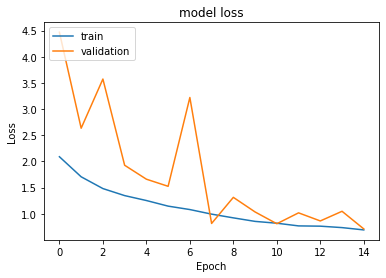

In [48]:
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [49]:
accuracy = model3.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 4s - loss: 0.6644 - accuracy: 0.7747 - 4s/epoch - 235ms/step


In [50]:
y_pred3=model3.predict(X_test_normalized)

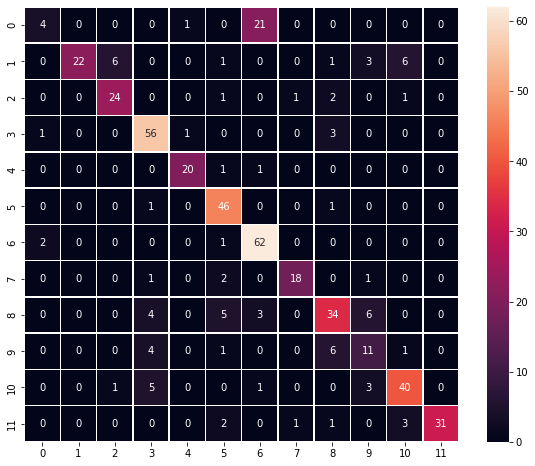

In [51]:
y_pred3_arg=np.argmax(y_pred3,axis=1)


confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred3_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

In [52]:
print(classification_report((y_test_arg),y_pred3_arg))

              precision    recall  f1-score   support

           0       0.57      0.15      0.24        26
           1       1.00      0.56      0.72        39
           2       0.77      0.83      0.80        29
           3       0.79      0.92      0.85        61
           4       0.91      0.91      0.91        22
           5       0.77      0.96      0.85        48
           6       0.70      0.95      0.81        65
           7       0.90      0.82      0.86        22
           8       0.71      0.65      0.68        52
           9       0.46      0.48      0.47        23
          10       0.78      0.80      0.79        50
          11       1.00      0.82      0.90        38

    accuracy                           0.77       475
   macro avg       0.78      0.74      0.74       475
weighted avg       0.78      0.77      0.76       475



Observation

Class 3,4,5, and 6 have a good recall scores, but class 0 has a very low recall score. The model is not overfitting. 

Transfer Learning using VGG16

In [58]:
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [59]:
vgg_model = VGG16(weights='imagenet', include_top = False, input_shape = (128,128,3))
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [60]:
for layer in vgg_model.layers:
    layer.trainable = False

In [61]:
model4 = Sequential()
model4.add(vgg_model)
model4.add(Flatten())

model4.add(Dense(32, activation='relu'))
model4.add(Dropout(0.1))
model4.add(Dense(16, activation='relu'))
model4.add(Dense(12, activation='softmax'))
opt=Adam()
model4.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 32)                262176    
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 12)                204       
                                                                 
Total params: 14,977,596
Trainable params: 262,908
Non-t

In [62]:
history_4 = model4.fit(
            X_train_normalized, y_train_encoded,
            epochs=15,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=16,
            verbose=2)

Epoch 1/15
241/241 - 645s - loss: 2.0639 - accuracy: 0.2763 - val_loss: 1.7680 - val_accuracy: 0.3318 - 645s/epoch - 3s/step
Epoch 2/15
241/241 - 652s - loss: 1.5840 - accuracy: 0.4302 - val_loss: 1.5488 - val_accuracy: 0.4346 - 652s/epoch - 3s/step
Epoch 3/15
241/241 - 652s - loss: 1.3703 - accuracy: 0.4934 - val_loss: 1.3196 - val_accuracy: 0.5117 - 652s/epoch - 3s/step
Epoch 4/15
241/241 - 657s - loss: 1.2055 - accuracy: 0.5651 - val_loss: 1.2226 - val_accuracy: 0.5841 - 657s/epoch - 3s/step
Epoch 5/15
241/241 - 650s - loss: 1.0677 - accuracy: 0.6145 - val_loss: 1.2329 - val_accuracy: 0.5701 - 650s/epoch - 3s/step
Epoch 6/15
241/241 - 649s - loss: 0.9840 - accuracy: 0.6421 - val_loss: 1.1786 - val_accuracy: 0.5748 - 649s/epoch - 3s/step
Epoch 7/15
241/241 - 649s - loss: 0.9375 - accuracy: 0.6652 - val_loss: 1.1591 - val_accuracy: 0.6051 - 649s/epoch - 3s/step
Epoch 8/15
241/241 - 646s - loss: 0.8695 - accuracy: 0.6914 - val_loss: 1.0661 - val_accuracy: 0.6449 - 646s/epoch - 3s/step


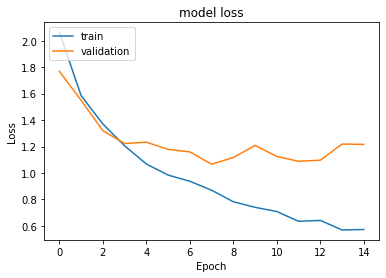

In [63]:
plt.plot(history_4.history['loss'])
plt.plot(history_4.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [64]:
accuracy = model4.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 70s - loss: 1.1462 - accuracy: 0.6463 - 70s/epoch - 5s/step


In [65]:
y_pred4=model4.predict(X_test_normalized)

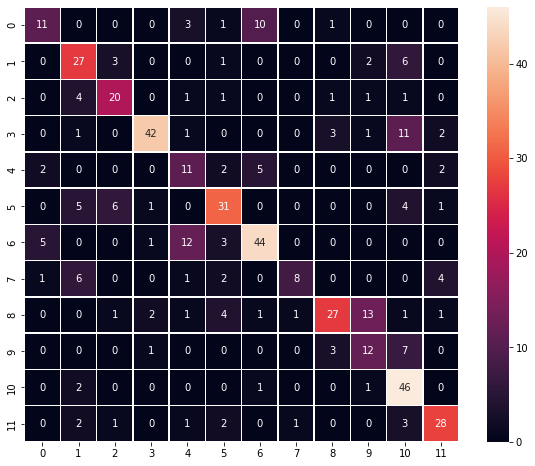

In [66]:
y_pred4_arg=np.argmax(y_pred4,axis=1)


confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred4_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

In [67]:
print(classification_report((y_test_arg),y_pred4_arg))

              precision    recall  f1-score   support

           0       0.58      0.42      0.49        26
           1       0.57      0.69      0.63        39
           2       0.65      0.69      0.67        29
           3       0.89      0.69      0.78        61
           4       0.35      0.50      0.42        22
           5       0.66      0.65      0.65        48
           6       0.72      0.68      0.70        65
           7       0.80      0.36      0.50        22
           8       0.77      0.52      0.62        52
           9       0.40      0.52      0.45        23
          10       0.58      0.92      0.71        50
          11       0.74      0.74      0.74        38

    accuracy                           0.65       475
   macro avg       0.64      0.61      0.61       475
weighted avg       0.68      0.65      0.65       475



Observation

Conclusion